In [16]:
"""
深度学习的算法本质上是通过反向传播求导数，PyTorch的Autograd模块实现了此功能。在Tensor上的所有操作，
Autograd都能为它们自动提供微分，避免手动计算导数的复杂过程。

autograd.Variable是Autograd中的核心类，它简单封装了Tensor，并支持几乎所有Tensor的操作。Tensor在被封装为Variable之后，
可以调用它的.backward实现反向传播，自动计算所有梯度
"""
from torch.autograd import Variable
import torch as t
import numpy as np
"""
Variable主要包含三个属性。

• data：保存计算后结果对应的的Tensor。
• grad：保存data对应的梯度，grad也是个Variable，而不是Tensor，它和data的形状一样。
• grad fn：指向一个Function对象，这个Function用来反向传播计算输入的梯度,requires_grad=True
Variable和Tensor具有近乎一致的接口，在实际使用中可以无缝切换。
"""
x=Variable(t.from_numpy(np.array([[1,2],[2,4]],dtype=float)),requires_grad=True)
print("张量x=",x)
y=x.sum()
print("输出y",y)
print("输出y的梯度",y.grad) #注意结果是y，所以y是没有梯度的，y进行反向传播，可以求导x的导数
print("y的反向梯度函数",y.grad_fn)
print("y的数据",y.data)
# 因为y=x[0][0]+x[0][1]+x[1][0]++x[1][1],可以认为四个数是四个变量，比如求每个变量的导数
# 假设是y=x1+x2+x3+x4  x1是自变量，x1的导树就是1，同理x2的导树也是1，最后就得到了4个1
# 注意每个点都有个梯度
y.backward() #反向传播计算梯度
print("x的梯度",x.grad)


"""
grad在反向传播过程中是累加的（accumulated），这意味着每次运行反向传播，
梯度都会累加之前的梯度，所以反向传播之前需把梯度清零。
"""
y.backward() #反向传播计算梯度
print(x.grad)
x.grad.data.zero_();
y.backward() #反向传播计算梯度
print(x.grad)


张量x= tensor([[1., 2.],
        [2., 4.]], dtype=torch.float64, requires_grad=True)
输出y tensor(9., dtype=torch.float64, grad_fn=<SumBackward0>)
输出y的梯度 None
y的反向梯度函数 <SumBackward0 object at 0x0000025F8F2D4D90>
y的数据 tensor(9., dtype=torch.float64)
x的梯度 tensor([[1., 1.],
        [1., 1.]], dtype=torch.float64)
tensor([[2., 2.],
        [2., 2.]], dtype=torch.float64)
tensor([[1., 1.],
        [1., 1.]], dtype=torch.float64)


D:\temp\ipykernel_9640\4188453072.py:23: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  print("输出y的梯度",y.grad) #注意结果是y，所以y是没有梯度的，y进行反向传播，可以求导x的导数


In [17]:
#计算x**2*e^x导数
#dx=2*x*e^x+x**2*e^x
#定义fx的函数逻辑
def f(x):
    return x**2*t.exp(x)
#我们预先知道他的梯度函数是
def graddx(x):
    return 2*x*t.exp(x)+x**2*t.exp(x)
#生成一个3*3随机矩阵，求梯度
x=Variable(t.rand(3,3),requires_grad=True)
print(graddx(x))
#使用反向传播求梯度
y=f(x)
y.backward(t.ones(y.size()))
print(x.grad)

tensor([[0.4463, 6.8922, 0.8426],
        [1.0312, 0.9291, 5.0900],
        [3.2036, 6.4868, 1.0162]], grad_fn=<AddBackward0>)
tensor([[0.4463, 6.8922, 0.8426],
        [1.0312, 0.9291, 5.0900],
        [3.2036, 6.4868, 1.0162]])


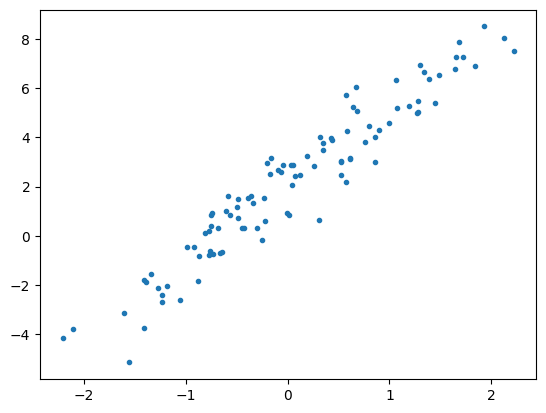

99 -0.6956086754798889 -0.5659545063972473


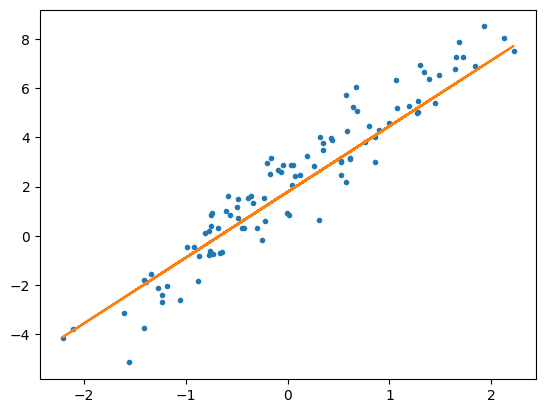

In [18]:
#使用autograd计算梯度，来实现线性回归
import torch as t
from torch.autograd import Variable as V
import matplotlib.pyplot as plot
t.manual_seed(42)
# 使用自动梯度实现线性回归
x=t.randn(100,1)
y=3*x+2+t.randn(100,1) #实际值上加上一些随机噪点
plot.plot(x,y,'.')
plot.show()
w=V(t.randn(1,1),requires_grad=True)
b=V(t.randn(1),requires_grad=True)
def fx(x):
   return t.mm(x,w)+b
def lossf(y_pre,y):
    return t.mean((y_pre-y)**2)
#训练100次，100次梯度下降，计算到最小损失时的w和b
w_gra_last,b_gra_last=0,0
for epoch in range(100):
    y_pre=fx(x)
    loss=lossf(y_pre,y)
    loss.backward()
    w_gra=w.grad.data
    b_gra=b.grad.data
    w_gra_last=w_gra.clone()
    b_gra_last=b_gra.clone()
    #如果梯度小于某个值直接退出
    if t.abs(w_gra)<=1e-8 and t.abs(b_gra)<=1e-8:
        break;
    learn_rate=0.01
    #注意w.sub_是不行的因为w是requires_grad=True，需要后面的参数都是设置为：requires_grad=True
    #所以只能是更新他的data
    w.data.sub_(w_gra*learn_rate)
    b.data.sub_(b_gra*learn_rate)
    #注意梯度清零，否则会累加
    w.grad.data.zero_()
    b.grad.data.zero_()
# w_gra_last是张量，item输出标量
print(epoch,w_gra_last.item(),b_gra_last.item())    
y_pre=fx(x)  
plot.plot(x,y,'.')
plot.plot(x.data.numpy(),y_pre.data.numpy())
plot.show()
    

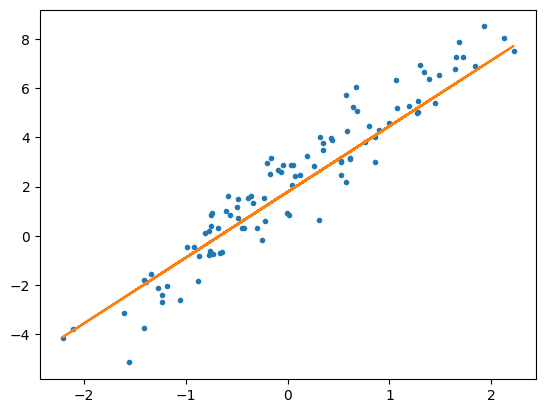

In [19]:
"""
在PyTorch中，torch.optim模块提供了许多优化算法，用于优化神经网络的参数。
以下是一些常用的优化算法和它们的使用示例：
SGD（随机梯度下降）优化器：
Adam（自适应矩估计）优化器：
Adagrad（自适应梯度）优化器：


在使用优化器时，你需要将模型的参数传递给优化器的构造函数，
并在每个训练迭代中调用zero_grad()方法清除梯度、backward()方法计算梯度，
最后调用step()方法来更新模型的参数。
"""
import torch as t
from torch.autograd import Variable as V
import matplotlib.pyplot as plot
t.manual_seed(42)
# 使用自动梯度实现线性回归
x=t.randn(100,1)
y=3*x+2+t.randn(100,1) #实际值上加上一些随机噪点
w=V(t.randn(1,1),requires_grad=True)
b=V(t.randn(1),requires_grad=True)
def fx(x):
   return t.mm(x,w)+b
def lossf(y_pre,y):
    return t.mean((y_pre-y)**2)
#定义优化器,第一个参数为模型的参数，参数传入后,自动获取他的梯度并且-梯度*学习率
optim=t.optim.SGD([w,b],lr=0.01)
#训练100次，100次梯度下降，计算到最小损失时的w和b
for epoch in range(100):
    y_pre=fx(x)
    #注意梯度清零，否则会累加
    optim.zero_grad()  
    loss=lossf(y_pre,y)
    loss.backward()
    #如果梯度小于某个值直接退出
    if t.abs(w.grad)<=1e-8 and t.abs(b.grad)<=1e-8:
        break;
    #更新参数w和b
    optim.step()
     
y_pre=fx(x)  
plot.plot(x,y,'.')
plot.plot(x.data.numpy(),y_pre.data.numpy())
plot.show()

In [20]:
#打印计算图
import torch
from torchviz import make_dot

# 定义一个简单的计算图
w= torch.randn(1, requires_grad=True)
b= torch.randn(1, requires_grad=True)
x = torch.randn(1, requires_grad=True)
y = w*x + b

# 使用make_dot函数绘制计算图,图上的数字只是代表数据的维度
dot = make_dot(y, params={'x': x, 'w': w, 'b': b}, show_attrs=True, show_saved=True)
dot.render(filename='compute_graph', format='png')


'compute_graph.png'